In [2]:
import torch
from transformers import AutoModelWithLMHead, AutoTokenizer
from sklearn.metrics import f1_score
def respond_to_batch(model, queries, txt_len=20, top_k=0, top_p=1.0):
    """Sample text from language model."""
    input_ids = queries
    for i in range(txt_len):
        # Get Logits
        outputs = model(input_ids)
        next_token_logits = outputs[0][:, -1, :]
        next_token_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
        # Sample
        probs = F.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
        input_ids = torch.cat([input_ids, next_token.unsqueeze(-1)], dim=-1)
    # return input_ids[:, -txt_len:]
    return input_ids[:, :]  # XD

# device = torch.device('cuda:0')
# model = AutoModelWithLMHead.from_pretrained('/home/yjzhou/transformers/examples/models/gpt2_sqli_rand4000_small/')
# _ = model.to(device)
# _ = model.eval()
tokenizer = AutoTokenizer.from_pretrained('gpt2')

bsz = 16
bos_token = '0'
bos_token_id = tokenizer._convert_token_to_id(bos_token)


In [26]:
# tokenizer = AutoTokenizer.from_pretrained('gpt2')


[1065, 2310, 1315, 1467, 362, 718, 657]

In [2]:
# idx=torch.nonzero((ids==657))[0]
# print(idx)
# idx=idx.repeat(1,768).reshape(1,1,768)
# idx

In [11]:
bos_token_id = tokenizer._convert_token_to_id(' !')
bos_token_id

50256

In [19]:
content=["0 2 5 0!!!","0 2 5 0! ","0 0!!"]
input_ids = []
attention_masks = []
indices=[]
max_length=5
tokenizer.pad_token ="!"
    # For every sentence...
for sent in content:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=max_length,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )
    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])
    print((encoded_dict['input_ids']))
#     print(type(encoded_dict['input_ids']))
#     print(torch.nonzero((encoded_dict['input_ids']==657)))
    idx=torch.nonzero((encoded_dict['input_ids']==657))
    if idx.shape[0]==0:
        print('sdfsdf')
        print(idx.shape)
        idx=torch.tensor(max_length-1)
#     [0][1]
    else:
        idx=idx[0][1]
    print(idx)
    idx=idx.repeat(1,1)
#     print(idx.shape)
#     idx=idx.reshape(1,1,768)
    indices.append(idx)
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
    
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
indices = torch.cat(indices, dim=0)

tensor([[   15,   362,   642,   657, 10185]])
tensor(3)
tensor([[ 15, 362, 642, 657,   0]])
tensor(3)
tensor([[  15,  657, 3228,    0,    0]])
tensor(1)


In [24]:
input_ids,indices

(tensor([[  15, 1105, 2310, 1467,  362],
         [  15,  362,  642,  718, 1105],
         [  15,  718, 9919, 1679,  657]]),
 tensor([[4],
         [4],
         [4]]))

In [22]:
idx=torch.nonzero((input_ids[0]==657))
idx

tensor([], size=(0, 1), dtype=torch.int64)

In [152]:
indices.shape,input_ids.shape,attention_masks.shape

(torch.Size([1, 1]), torch.Size([1, 5]), torch.Size([1, 5]))

In [103]:
indices.repeat(1,4).reshape(indices.shape[0],1,4)

tensor([[[3, 3, 3, 3]],

        [[6, 6, 6, 6]],

        [[3, 3, 3, 3]]])

In [40]:
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)
transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)

==== First Transformer ====

transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072,

In [18]:
input_ids=input_ids.to(device)

In [19]:
input_ids

tensor([[ 1065,  2310,  1315,  1467,   362,   718,   657, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [   17,   642,   718,  1105,  1315,   657, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [   21,  9919,   657, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]],
       device='cuda:0')

In [6]:
attention_masks=attention_masks.to(device)

In [9]:
out=model.transformer(input_ids,attention_mask=attention_masks)

In [10]:
out[0].shape

torch.Size([3, 20, 768])

In [47]:
out[0][:,-1:,:].shape

torch.Size([3, 1, 50257])

In [45]:
out[0].shape

torch.Size([3, 20, 50257])

In [2]:
queries = torch.LongTensor([[bos_token_id]]).expand(bsz, 1)

In [7]:
queries
from transformers.modeling_utils import top_k_top_p_filtering
from torch.nn import Identity
import torch.nn.functional as F

In [8]:
queries = queries.to(device)
outputs = respond_to_batch(model, queries, txt_len=60, top_k=20)

In [10]:
outputs.shape

torch.Size([16, 61])

In [ ]:
with open('/home/yjzhou/transformers/examples/choice.txt','a') as f1:
    for j in range(0,1000):
        queries = torch.LongTensor([[bos_token_id]]).expand(bsz, 1)
        queries = queries.to(device)
        outputs = respond_to_batch(model, queries, txt_len=60, top_k=20)
    
        for i in range(len(outputs)):
            tmpstr = tokenizer.decode(outputs[i])
            #print(tmpstr)
            count = tmpstr.find('0!',1)
            #print(tmpstr[:count])
            if count != -1:
                f1.write(tmpstr[:count])
                f1.write('\n')
f1.close()

In [75]:
import torch
indices=torch.LongTensor([[2],[1],[0]]).repeat(1,4).reshape(3,1,4)
print(indices.shape)
indices

torch.Size([3, 1, 4])


tensor([[[2, 2, 2, 2]],

        [[1, 1, 1, 1]],

        [[0, 0, 0, 0]]])

In [18]:
data=torch.LongTensor([[[1,1,1,1],[2,2,2,2],[3,3,3,3]],[[4,4,4,4],[5,5,5,5],[6,6,6,6]],[[7,7,7,7],[8,8,8,8],[9,9,9,9]]])
print(data.shape)
data

torch.Size([3, 3, 4])


tensor([[[1, 1, 1, 1],
         [2, 2, 2, 2],
         [3, 3, 3, 3]],

        [[4, 4, 4, 4],
         [5, 5, 5, 5],
         [6, 6, 6, 6]],

        [[7, 7, 7, 7],
         [8, 8, 8, 8],
         [9, 9, 9, 9]]])

In [24]:
torch.gather(data,1,indices)

tensor([[[3, 3, 3, 3]],

        [[5, 5, 5, 5]],

        [[7, 7, 7, 7]]])

In [2]:
import datetime
import numpy as np
import os

In [7]:
#开始的地方********
import pandas as pd
from sklearn.metrics import f1_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch.nn as nn
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import time
from torch.nn import CrossEntropyLoss
import datetime
import os
import numpy as np
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [8]:
# import pandas as pd
train=pd.read_csv('/data/hdj/data/CodeBERT/train_0206.csv')
# data.head()
val=pd.read_csv('/data/hdj/data/CodeBERT/val_0206.csv')
test=pd.read_csv('/data/hdj/data/CodeBERT/test_0206.csv')
# test.head()


In [9]:
train

,content,label
0,0 2 3 108 4 110 8 84 6 59 62 9 77 6 59 63 7 33...,0
1,0 2 3 108 4 110 5 70 6 59 62 10 7 32 8 85 6 59...,1
2,0 2 3 108 4 110 5 72 6 59 62 7 33 16 83 6 59 6...,0
3,0 1 12 3 108 4 109 6 59 63 7 33 16 82 6 59 63 ...,0
4,0 1 12 66 104 4 110 6 59 63 7 33 16 83 6 59 62...,0
...,...,...
12955,0 1 12 3 108 6 59 63 7 32 8 84 6 59 63 34 43 3...,0
12956,0 2 3 108 4 110 5 68 6 59 62 7 32 8 85 6 59 63...,1
12957,0 2 3 108 4 109 5 72 6 59 62 10 7 33 16 82 6 5...,0
12958,0 2 3 108 4 110 8 84 6 59 62 9 75 6 59 63 7 32...,0


In [5]:
train.shape,val.shape,test.shape,sum(train['label'].values)/train.shape[0],sum(val['label'].values)/val.shape[0],sum(test['label'].values)/test.shape[0],

((12960, 2),
 (3240, 2),
 (4050, 2),
 0.1705246913580247,
 0.17037037037037037,
 0.17037037037037037)

In [6]:
a=torch.tensor([1,2,3])
index=[0,1]
# a[index]>0
filterIndex=[]
for ind in index:
    if a[ind]>0:
        filterIndex.append(ind)
filterIndex

[0, 1]

In [8]:
def data_prepare(file_path, tokenizer, max_len=66, mode='train'):
    '''
    file_path: the path to input file.
                In train mode, the input must be a tsv file that includes two columns where the first is text, and second column is label.
                The first row must be header of columns.

                In predict mode, the input must be a tsv file that includes only one column where the first is text.
                The first row must be header of column.

    lab2ind: dictionary of label classes
    tokenizer: BERT tokenizer
    max_len: maximal length of input sequence
    mode: train or predict
    '''
    # if we are in train mode, we will load two columns (i.e., text and label).
    if mode == 'train':
        # Use pandas to load dataset
        df = pd.read_csv(file_path, delimiter=',', header=0, names=['content', 'label'])
        print("Data size ", df.shape)
        labels = df.label.values

        # Create sentence and label lists
        labels = [i for i in labels]
        print("Label is ", labels[0])

        # Convert data into torch tensors
        labels = torch.tensor(labels)

    # if we are in predict mode, we will load one column (i.e., text).
    elif mode == 'predict':
        df = pd.read_csv(file_path, delimiter=',', header=0, names=['content'])
        print("Data size ", df.shape)
        # create placeholder
        labels = []
    else:
        print("the type of mode should be either 'train' or 'predict'. ")
        return

    # Create sentence and label lists
    content = df.content.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    indices=[]
    tokenizer.pad_token = "!"
    # For every sentence...
    for sent in content:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_len,  # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',  # Return pytorch tensors.
        )
        
        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])
        idx = torch.nonzero((encoded_dict['input_ids'] == 657))
        if idx.shape[0]==0:
            idx=torch.tensor(max_len-1)
        else:
            idx=idx[0][1]
#         if idx==60：
#         print(idx)
        idx = idx.repeat(1, 1)
#         try:
#             idx = torch.nonzero((encoded_dict['input_ids'] == 657))[0][1]
#             idx = idx.repeat(1, 1)
#         except:
#             print(content,encoded_dict['input_ids'])
#             break
        
        indices.append(idx)
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    indices = torch.cat(indices, dim=0)
#     print("The first sentence untokenized:\n", content[0])
#     print("Index numbers of the first sentence after padding:\n", input_ids[0])

    return input_ids,  attention_masks,labels,indices

In [7]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')


In [9]:

path="/data/hdj/data/CodeBERT/"
# Use defined funtion to extract data
train_inputs,  train_masks,train_labels,train_indices = data_prepare(path+"train_0206.csv",tokenizer)
validation_inputs, validation_masks ,validation_labels, val_indices= data_prepare(path+"val_0206.csv",tokenizer)
test_inputs,  test_masks,test_labels,test_indices = data_prepare(path+"test_0206.csv",tokenizer)

Data size  (12960, 2)
Label is  0
Data size  (3240, 2)
Label is  0
Data size  (4050, 2)
Label is  0


In [10]:
print(train_inputs.shape,train_masks.shape,train_labels.shape,train_indices.shape)
print(validation_inputs.shape, validation_masks.shape ,validation_labels.shape, val_indices.shape)
print(test_inputs.shape, test_masks.shape ,test_labels.shape, test_indices.shape)

torch.Size([12960, 66]) torch.Size([12960, 66]) torch.Size([12960]) torch.Size([12960, 1])
torch.Size([3240, 66]) torch.Size([3240, 66]) torch.Size([3240]) torch.Size([3240, 1])
torch.Size([4050, 66]) torch.Size([4050, 66]) torch.Size([4050]) torch.Size([4050, 1])


In [11]:
batch_size = 128
# Combine the training inputs into a TensorDataset.
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataset = TensorDataset(train_inputs, train_masks, train_labels,train_indices)
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
val_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels,val_indices)
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataset = TensorDataset(test_inputs, test_masks, test_labels,test_indices)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [12]:
# Cell

class ValueHead(torch.nn.Module):
    """The ValueHead class implements a head for GPT2 that returns a scalar for each output token."""
    def __init__(self, num_labels):
        super().__init__()
        self.drop = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
    def forward(self, hidden_states):
        output = hidden_states
#         output = self.drop(output)
        output = self.classifier(output)
        return output

# Cell

class SentimentModel(torch.nn.Module):
    """The GPT2HeadWithValueModel class implements a GPT2 language model with a secondary, scalar head."""
    def __init__(self, model_path,num_labels):
        super().__init__()
#         config.num_labels = 2
        if(os.path.exists(model_path)):
            self.model = AutoModelWithLMHead.from_pretrained(model_path)
        else:
            print("error model path not exists")
#         self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.v_head = ValueHead(num_labels)
#         self.loss_fn=CrossEntropyLoss()
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        indices=None,
#         label=None,
    ):

        transformer_outputs = self.model.transformer(
            input_ids,
            attention_mask=attention_mask,
        )
        indices=indices.repeat(1,768).reshape(indices.shape[0],1,768)
#         print('transformer_outputs ',type(transformer_outputs),transformer_outputs[0].shape)
#         print('indices ',type(indices),indices.shape)
        
        hidden_states=torch.gather(transformer_outputs[0],1,indices)
#         print('hidden_states ',type(hidden_states),hidden_states.shape)
        
        logits = torch.squeeze(self.v_head(hidden_states),1) 
        return logits
#         print('logits.shape:  ****',logits.shape)
#         print('labels.shape: ',label.shape)
#         print()
#         if(label!=None):
#             loss=self.loss_fn(logits,label)
#         else:
#             loss=None
#         return loss,logits
        


In [72]:
loss = nn.CrossEntropyLoss()
input = torch.Tensor([[1,0],[0.2,0.8],[0.5,0.5]])
input,input.shape

(tensor([[1.0000, 0.0000],
         [0.2000, 0.8000],
         [0.5000, 0.5000]]),
 torch.Size([3, 2]))

In [73]:
target = torch.empty(3, dtype=torch.long).random_(2)
target,target.shape

(tensor([0, 0, 1]), torch.Size([3]))

In [74]:
output = loss(input, target)
output

tensor(0.6813)

In [13]:
model_path='/data/yjzhou/bigdatamodel2/'
# model_path='/home/yjzhou/transformers/examples/models/gpt2_sqli_rand4000_small/'

num_labels=2
model=SentimentModel(model_path,num_labels)
# device = torch.device('cuda:0')
device = torch.device("cuda" if torch.cuda.is_available()   else "cpu")
_ = model.to(device)
_ = model.eval()

In [14]:

lr = 2e-5
max_grad_norm = 1.0
epochs = 4
warmup_proportion = 0.1
num_training_steps  = len(train_dataloader) * epochs
num_warmup_steps = num_training_steps * warmup_proportion

### In Transformers, optimizer and schedules are instantiated like this:
# Note: AdamW is a class from the huggingface library
# the 'W' stands for 'Weight Decay"
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)
# schedules
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

# We use nn.CrossEntropyLoss() as our loss function.
# criterion = nn.CrossEntropyLoss()

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


In [50]:
for step, batch in enumerate(train_dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    b_indices=batch[3].to(device)
    print(b_input_ids.shape,b_input_mask.shape,b_labels.shape,b_indices.shape)
    break
for step, batch in enumerate(validation_dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    b_indices=batch[3].to(device)
    print(b_input_ids.shape,b_input_mask.shape,b_labels.shape,b_indices.shape)
    break

torch.Size([32, 60]) torch.Size([32, 60]) torch.Size([32]) torch.Size([32, 1])
torch.Size([32, 60]) torch.Size([32, 60]) torch.Size([32]) torch.Size([32, 1])


In [15]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()
def acc_and_f1(preds, labels):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds)
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
    }
def compute_metrics(preds, labels):
    assert len(preds) == len(labels)
   
    return acc_and_f1(preds, labels)


In [16]:
# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_indices=batch[3].to(device)
        model.zero_grad()
        logits = model(b_input_ids,attention_mask=b_input_mask,indices=b_indices)
        loss_fn=CrossEntropyLoss()
        loss=loss_fn(logits,b_labels)
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
#         break
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    total_eval_acc=0
    total_eval_acc_and_f1=0
    total_eval_f1=0
    
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_indices = batch[3].to(device)
        with torch.no_grad():
#             loss, logits = model(b_input_ids,attention_mask=b_input_mask,label=b_labels,indices=b_indices)
            logits = model(b_input_ids,attention_mask=b_input_mask,indices=b_indices)
            loss_fn=CrossEntropyLoss()
            loss=loss_fn(logits,b_labels)
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        preds_label = np.argmax(logits, axis=1)
        result = compute_metrics( preds_label, label_ids)
#         for key in sorted(result.keys()):
#             print("%s = %s\n" % (key, str(result[key])))
        total_eval_acc+=result['acc']
        total_eval_acc_and_f1+=result['acc_and_f1']
        total_eval_f1+=result['f1']
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  total_eval_acc: {0:.2f}".format(total_eval_acc/len(validation_dataloader)))
    print("  total_eval_acc_and_f1: {0:.2f}".format(total_eval_acc_and_f1/len(validation_dataloader)))
    print("  total_eval_f1: {0:.2f}".format(total_eval_f1/len(validation_dataloader)))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    # Create checkpoint at end of each epoch
    state = {
        'epoch': epoch_i,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
    }
    torch.save(state, "" + str(epoch_i + 1) + ".pt")
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))



======== Epoch 1 / 4 ========
Training...


/home/hdj/anaconda3/envs/waf/lib/python3.7/site-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


  Batch    40  of    405.    Elapsed: 0:00:04.
  Batch    80  of    405.    Elapsed: 0:00:08.
  Batch   120  of    405.    Elapsed: 0:00:12.
  Batch   160  of    405.    Elapsed: 0:00:16.
  Batch   200  of    405.    Elapsed: 0:00:21.
  Batch   240  of    405.    Elapsed: 0:00:25.
  Batch   280  of    405.    Elapsed: 0:00:29.
  Batch   320  of    405.    Elapsed: 0:00:33.
  Batch   360  of    405.    Elapsed: 0:00:37.
  Batch   400  of    405.    Elapsed: 0:00:41.

  Average training loss: 0.16
  Training epcoh took: 0:00:41

Running Validation...
acc = 0.96875

acc_and_f1 = 0.9510416666666667

f1 = 0.9333333333333333

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 0.96875

acc_and_f1 = 0.9580592105263158

f1 = 0.9473684210526316

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.

/home/hdj/anaconda3/envs/waf/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



======== Epoch 2 / 4 ========
Training...
  Batch    40  of    405.    Elapsed: 0:00:04.
  Batch    80  of    405.    Elapsed: 0:00:08.
  Batch   120  of    405.    Elapsed: 0:00:12.
  Batch   160  of    405.    Elapsed: 0:00:16.
  Batch   200  of    405.    Elapsed: 0:00:20.
  Batch   240  of    405.    Elapsed: 0:00:24.
  Batch   280  of    405.    Elapsed: 0:00:29.
  Batch   320  of    405.    Elapsed: 0:00:33.
  Batch   360  of    405.    Elapsed: 0:00:37.
  Batch   400  of    405.    Elapsed: 0:00:41.

  Average training loss: 0.04
  Training epcoh took: 0:00:41

Running Validation...
acc = 0.96875

acc_and_f1 = 0.9510416666666667

f1 = 0.9333333333333333

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_an

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 0.96875

acc_and_f1 = 0.9605654761904762

f1 = 0.9523809523809523

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 0.96875

acc_and_f1 = 0.9389204545454546

f1 = 0.9090909090909091

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 0.96875

acc_and_f1 = 0.9288194444444444

f1 = 0.888888888888889

acc = 0.96875

acc_and_f1 = 0.8177083333333333

f1 = 0.6666666666666666

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 0.96875

acc_and_f1 = 0.9389204545454546

f1 = 0.9090909090909091

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 1.0

acc_and_f1 = 1.0

f1 = 1.0

acc = 0.96875

acc_and_f1 = 0.9389204545454546

f1 

In [ ]:
# state = {
#         'epoch': epoch_i,
#         'state_dict': model.state_dict(),
#         'optimizer': optimizer.state_dict(),
#         'scheduler': scheduler.state_dict()
#     }
# torch.save(state, "" + str(epoch_i + 1) + ".pt")

In [17]:
# 保存和加载整个模型
torch.save(model, 'model.pkl')
model_test = torch.load('model.pkl')
# 仅保存和加载模型参数(推荐使用)
# torch.save(model_object.state_dict(), 'params.pkl')
# model_object.load_state_dict(torch.load('params.pkl'))

In [100]:
def load_checkpoint(model, checkpoint_PATH, optimizer):
    if checkpoint_PATH != None:
        model_CKPT = torch.load(checkpoint_PATH)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
    return model, optimizer
model_load=GPT2HeadWithValueModel("/data/yjzhou/bigdatamodel/",num_labels)
optimizer_load = AdamW(model.parameters(), lr=lr, correct_bias=False)
# schedules
scheduler_load = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

model,optimizer_load=load_checkpoint(model_load,'/home/hdj/trl/nbs/4.pt',optimizer_load)

loading checkpoint!


In [ ]:
# train_inputs,  train_masks,train_labels,train_indices =
# validation_inputs, validation_masks ,validation_labels, val_indices
# data_inputs=train_inputs+validation_inputs

In [19]:
data_inputs=torch.cat((train_inputs,validation_inputs),0)
data_masks=torch.cat((train_masks,validation_masks),0)
data_labels=torch.cat((train_labels,validation_labels),0)
data_indices=torch.cat((train_indices,val_indices),0)

In [20]:
data_inputs.shape,data_masks.shape,data_labels.shape,data_indices.shape

(torch.Size([16200, 66]),
 torch.Size([16200, 66]),
 torch.Size([16200]),
 torch.Size([16200, 1]))

In [21]:
batch_size = 128
# Combine the training inputs into a TensorDataset.
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
data_dataset = TensorDataset(data_inputs, data_masks, data_labels,data_indices)
data_dataloader = DataLoader(
            data_dataset,  # The training samples.
            sampler = RandomSampler(data_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

In [22]:
#用完整的数据训练
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(data_dataloader):
        # Progress update every 40 batches.
        if step % 128 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_indices=batch[3].to(device)
        model.zero_grad()
        logits = model(b_input_ids,attention_mask=b_input_mask,indices=b_indices)
        loss_fn=CrossEntropyLoss()
        loss=loss_fn(logits,b_labels)
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
#         break
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    405.    Elapsed: 0:00:12.
  Batch    80  of    405.    Elapsed: 0:00:25.
  Batch   120  of    405.    Elapsed: 0:00:37.

  Average training loss: 0.00
  Training epcoh took: 0:00:39


======== Epoch 2 / 4 ========
Training...
  Batch    40  of    405.    Elapsed: 0:00:13.
  Batch    80  of    405.    Elapsed: 0:00:25.
  Batch   120  of    405.    Elapsed: 0:00:37.

  Average training loss: 0.00
  Training epcoh took: 0:00:40


======== Epoch 3 / 4 ========
Training...
  Batch    40  of    405.    Elapsed: 0:00:13.
  Batch    80  of    405.    Elapsed: 0:00:25.
  Batch   120  of    405.    Elapsed: 0:00:38.

  Average training loss: 0.00
  Training epcoh took: 0:00:40


======== Epoch 4 / 4 ========
Training...
  Batch    40  of    405.    Elapsed: 0:00:13.
  Batch    80  of    405.    Elapsed: 0:00:25.
  Batch   120  of    405.    Elapsed: 0:00:38.

  Average training loss: 0.00
  Training epcoh took: 0:00:40



In [23]:
# 保存和加载整个模型
torch.save(model, 'model.pkl')
model_test = torch.load('model.pkl')

In [24]:
# Tracking variables
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
total_eval_acc=0
total_eval_f1_acc=0
total_eval_f1=0
eval_f1_acc=[]
total_eval_acc_and_f1=0
# Evaluate data for one epoch
for batch in test_dataloader:
    model_test.eval()
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    b_indices = batch[3].to(device)
    with torch.no_grad():
        logits = model_test(b_input_ids,attention_mask=b_input_mask,indices=b_indices)
        loss_fn=CrossEntropyLoss()
        loss=loss_fn(logits,b_labels)
    # Accumulate the validation loss.
    total_eval_loss += loss.item()
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    preds_label = np.argmax(logits, axis=1)
    result = compute_metrics( preds_label, label_ids)
#     for key in sorted(result.keys()):
#         print("%s = %s\n" % (key, str(result[key])))
    total_eval_acc+=result['acc']
    total_eval_acc_and_f1+=result['acc_and_f1']
    eval_f1_acc.append(result['acc_and_f1'])
    total_eval_f1+=result['f1']
    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)
# Report the final accuracy for this validation run.
avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
print("  total_eval_acc: {0:.2f}".format(total_eval_acc/len(test_dataloader)))
print("  total_eval_acc_and_f1: {0:.2f}".format(total_eval_acc_and_f1/len(test_dataloader)),total_eval_acc_and_f1,len(test_dataloader))
print("  total_eval_f1: {0:.2f}".format(total_eval_f1/len(test_dataloader)))
# Calculate the average loss over all of the batches.
avg_val_loss = total_eval_loss / len(test_dataloader)
# Measure how long the validation run took.
validation_time = format_time(time.time() - t0)
print("  Validation Loss: {0:.2f}".format(avg_val_loss))
print("  Validation took: {:}".format(validation_time))

  Accuracy: 0.99
  total_eval_acc: 0.99
  total_eval_acc_and_f1: 0.99 125.65736173548675 127
  total_eval_f1: 0.98
  Validation Loss: 0.02
  Validation took: 0:00:51


In [25]:
#在model生成的样本上测试打分的分布
model_test_inputs,  model_test_masks,model_test_labels,model_test_indices = data_prepare(path+"dataset15991.csv",tokenizer)
model_test_dataset = TensorDataset(model_test_inputs, model_test_masks, model_test_labels,model_test_indices)
model_test_dataloader = DataLoader(
            model_test_dataset, # The validation samples.
            sampler = SequentialSampler(model_test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Data size  (15991, 2)
Label is  0


In [29]:
s=[1,2,3]
d=[4,5]
s+=d
s

[1, 2, 3, 4, 5]

In [35]:
# Tracking variables
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
total_eval_acc=0
total_eval_f1_acc=0
total_eval_f1=0
eval_f1_acc=[]
total_eval_acc_and_f1=0
scores=[]
# Evaluate data for one epoch
for batch in model_test_dataloader:
    model_test.eval()
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    b_indices = batch[3].to(device)
    with torch.no_grad():
        logits = model_test(b_input_ids,attention_mask=b_input_mask,indices=b_indices)
        loss_fn=CrossEntropyLoss()
        loss=loss_fn(logits,b_labels)
    # Accumulate the validation loss.
    total_eval_loss += loss.item()
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    scores+=list(logits[:,1])
    label_ids = b_labels.to('cpu').numpy()
    preds_label = np.argmax(logits, axis=1)
    result = compute_metrics( preds_label, label_ids)
#     for key in sorted(result.keys()):
#         print("%s = %s\n" % (key, str(result[key])))
    total_eval_acc+=result['acc']
    total_eval_acc_and_f1+=result['acc_and_f1']
    eval_f1_acc.append(result['acc_and_f1'])
    total_eval_f1+=result['f1']
    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)
# Report the final accuracy for this validation run.
avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
print("  total_eval_acc: {0:.2f}".format(total_eval_acc/len(test_dataloader)))
print("  total_eval_acc_and_f1: {0:.2f}".format(total_eval_acc_and_f1/len(test_dataloader)),total_eval_acc_and_f1,len(test_dataloader))
print("  total_eval_f1: {0:.2f}".format(total_eval_f1/len(test_dataloader)))
# Calculate the average loss over all of the batches.
avg_val_loss = total_eval_loss / len(test_dataloader)
# Measure how long the validation run took.
validation_time = format_time(time.time() - t0)
print("  Validation Loss: {0:.2f}".format(avg_val_loss))
print("  Validation took: {:}".format(validation_time))

  Accuracy: 0.98
  total_eval_acc: 0.98
  total_eval_acc_and_f1: 0.97 123.56935987599041 127
  total_eval_f1: 0.97
  Validation Loss: 0.03
  Validation took: 0:12:40


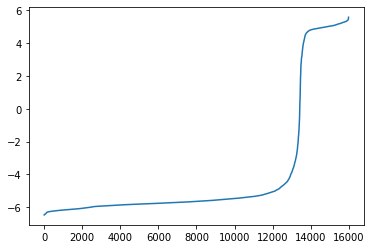

In [39]:
import matplotlib.pyplot as plt
#对score进行排序 画出分布图
scores=sorted(scores)
len(scores),scores[:10]
x=[i for i in range(len(scores))]
plt.plot(x, scores)  

In [161]:
rewards=np.array([-8,-20,5,1,2,-3,3,0,-90,-89])

In [162]:
rewards_index = sorted(range(len(rewards)), key=lambda k: rewards[k],reverse=False)  # 升序排序 reversed=False
rewards_index

[8, 9, 1, 0, 5, 7, 3, 4, 6, 2]

In [166]:
rewards_index[-4:-1]

[3, 4, 6]

In [163]:
rewards_sorted=sorted(rewards)
rewards_sorted

[-90, -89, -20, -8, -3, 0, 1, 2, 3, 5]

In [200]:
posNum=np.sum(rewards>=0)
if posNum*2<len(rewards):#做数据均衡处理
    
    largeNegNum=int(posNum*0.8)#采样数量
    print('largeRotioNeg :',largeNegNum)
    smallNegNum=posNum-largeNegNum#采样数量
    print('smallRotioNeg :',smallNegNum)
    choiceSmall=rewards_index[:len(rewards)-posNum-posNum]
    choiceLarge=rewards_index[-posNum-posNum:-posNum]
    print('choiceSmall :',choiceSmall)
    print('choiceLarge :',choiceLarge)
    largeIndex = np.random.choice(choiceLarge,size=largeNegNum, replace=False)
    smallIndex = np.random.choice(choiceSmall,size=smallNegNum, replace=False)
    posIndex=rewards_index[-posNum:]
    print('smallIndex :',smallIndex)
    print('largeIndex :',largeIndex)
    print('posIndex :',posIndex)
    print(type(posIndex),type(smallIndex),type(largeIndex),)
    allIndex=posIndex+list(smallIndex)+list(largeIndex)
    print('allIndex :',allIndex)


#     p=pSmall+pLarge
#     print('p :',p)

In [195]:
query_tensors= np.random.rand(10, 2)
query_selected=query_tensors[allIndex,:]
response_tensors=np.random.rand(10, 2)
response_selected=response_tensors[allIndex,:]
rewards=np.random.rand(10, 2)
rewards_selected=rewards[allIndex,:]

In [196]:
allIndex 

[3, 4, 6, 2, 8, 1, 5, 0]

In [198]:
rewards_selected

array([[0.33898512, 0.17949026],
       [0.1709866 , 0.46345098],
       [0.60825287, 0.59665541],
       [0.33940382, 0.48954894],
       [0.05037006, 0.69909807],
       [0.94412352, 0.74999925],
       [0.87457296, 0.94411975],
       [0.23074234, 0.7649117 ]])

In [197]:
rewards

array([[0.23074234, 0.7649117 ],
       [0.94412352, 0.74999925],
       [0.33940382, 0.48954894],
       [0.33898512, 0.17949026],
       [0.1709866 , 0.46345098],
       [0.87457296, 0.94411975],
       [0.60825287, 0.59665541],
       [0.78364425, 0.5000263 ],
       [0.05037006, 0.69909807],
       [0.9923964 , 0.26726254]])

In [46]:
a = np.array(scores)
print('0 :', np.percentile(a, 0))
print('10', np.percentile(a, 10))
print('20 :', np.percentile(a, 20))
print('30', np.percentile(a, 30))
print('40 :', np.percentile(a, 40))
print('50 :', np.median(a))
print('60 :', np.percentile(a, 60))
print('70 :', np.percentile(a, 70))
print('80 :', np.percentile(a, 80))
print('82 :', np.percentile(a, 82))
print('83 :', np.percentile(a, 83))
print('84 :', np.percentile(a, 84))
print('85 :', np.percentile(a, 85))
print('90 :', np.percentile(a, 90))
print('100 :', np.percentile(a, 100))

0 : -6.477573394775391
10 -6.121445655822754
20 : -5.9216203689575195
30 -5.825961589813232
40 : -5.745595932006836
50 : -5.6540647
60 : -5.5162353515625
70 : -5.320635795593262
80 : -4.403904438018799
82 : -3.534460449218751
83 : -2.7513177394866943
84 : 0.10986618995668951
85 : 3.8011064529418945
90 : 4.911001682281494
100 : 5.585479736328125


In [123]:
#策略 保留所有>=0的例子，然后从所有<0的例子里采样相同size的数据
# np.random.seed(0)
# np.random.choice(5, 3, replace=False, p=[0.1, 0, 0.3, 0.6, 0])
# array([2, 3, 0])
p = np.array([0.1, 0.0, 0.5, 0.4])
index = np.random.choice([0, 1, 2, 3],size=3, replace=False,p = p.ravel())
index

array([2, 0, 3])

In [24]:
len(eval_f1_acc),len(test_dataloader)

(22, 22)

In [31]:
sum(eval_f1_acc)/len(eval_f1_acc)

0.9375673884196611

In [92]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.2644691658988595,
  'Valid. Loss': 0.15922592911043798,
  'Valid. Accur.': 0.9431818181818182,
  'Training Time': '0:04:30',
  'Validation Time': '0:00:09'},
 {'epoch': 2,
  'Training Loss': 0.10734188155736774,
  'Valid. Loss': 0.11009371190712872,
  'Valid. Accur.': 0.9673295454545454,
  'Training Time': '0:04:32',
  'Validation Time': '0:00:10'},
 {'epoch': 3,
  'Training Loss': 0.05057939318264835,
  'Valid. Loss': 0.04962746564739395,
  'Valid. Accur.': 0.9872159090909091,
  'Training Time': '0:04:36',
  'Validation Time': '0:00:10'},
 {'epoch': 4,
  'Training Loss': 0.033867501211352645,
  'Valid. Loss': 0.042183015490247104,
  'Valid. Accur.': 0.9900568181818182,
  'Training Time': '0:04:36',
  'Validation Time': '0:00:09'}]

In [205]:
[{'epoch': 1,
  'Training Loss': 1.0033449912071228,
  'Valid. Loss': 0.9445437436754053,
  'Valid. Accur.': 0.1434659090909091,
  'Training Time': '0:04:23',
  'Validation Time': '0:00:10'},
 {'epoch': 2,
  'Training Loss': 0.9981416406631469,
  'Valid. Loss': 0.9445437436754053,
  'Valid. Accur.': 0.1434659090909091,
  'Training Time': '0:04:26',
  'Validation Time': '0:00:10'},
 {'epoch': 3,
  'Training Loss': 0.9991825561523437,
  'Valid. Loss': 0.9445437436754053,
  'Valid. Accur.': 0.1434659090909091,
  'Training Time': '0:04:24',
  'Validation Time': '0:00:10'},
 {'epoch': 4,
  'Training Loss': 0.9964690442085267,
  'Valid. Loss': 0.9445437436754053,
  'Valid. Accur.': 0.1434659090909091,
  'Training Time': '0:04:27',
  'Validation Time': '0:00:10'}]

In [3]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
data=pd.read_csv('/data/hdj/data/CodeBERT/trainAll_0206.csv')
X = np.array(data['content'])
y = np.array(data['label'])
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
print(split )       # doctest: +ELLIPSIS

# StratifiedShuffleSplit(n_splits=3, random_state=0, ...)
for train_index, test_index in split.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
train=pd.DataFrame()
train['content']=X_train
train['label']=y_train
train.to_csv('/data/hdj/data/CodeBERT/train_0206.csv',index=False)
val=pd.DataFrame()
val['content']=X_test
val['label']=y_test
val.to_csv('/data/hdj/data/CodeBERT/val_0206.csv',index=False)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)
TRAIN: [  369  3199 13563 ... 12122  3547 11232] TEST: [ 4646  9359  4122 ...  9726  3141 12199]


In [ ]:
#转变最初的txt格式到csv格式
for path in ['/home/hdj/data/CodeBERT/eval.csv']:#,'/home/hdj/data/CodeBERT/train.csv'
    with open(path) as f_in:
        contents=[]
        labels=[]
        for line in f_in:

            line=line.replace(',',' ')
            line=line.split('||')

            left=line[0].strip()
            right=line[1].strip()
    #         print(left,label)
            contents.append(left)
            labels.append(right)
        data=pd.DataFrame()
        data['content']=contents
        data['label']=labels
        data.to_csv('/home/hdj/data/CodeBERT/eval_hdj.csv',index=False)